# 2022-MM-DD_001__NAME

- This notebook is primarily intended for data acquisition (and viewing the recordings after acquisition). 
- Post-processing can be done in this notebook, but would be probably better done in a separate notebook 
- _(all metadata, including AWG modulation, is included with every measurement and can be queried from the datafile)._**

### Scripts & data

In [ ]:
isHot = True  # This variable decides on the global state of the notebook. isHot = instruments are connected and controlled, data is acquired and saved.
isSaving = isHot and True

# Native libraries
import pickle, sys, lzma, warnings, os, sys, importlib
sys.path.insert(0,'C:/git/StrathLab/libs') #Lab PC
sys.path.insert(0,'D:/Repositories/StrathLab/libs') #XMG

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import StrathLabToolkit as lab
importlib.reload(lab)
from IPython.display import Markdown #for text coloring

awg, rth, sm, datadir_full = lab.Initialise_Notebook(isHot)

### AWG Waveforms

In [ ]:
samplerate = 1e9 #between 125e6 and 12e9
using_AWG_channels = (1,) #(1,2) # Denominate used channels: (1,),(2,),(1,2) or 'None' if no modulation
wf_rounding_factor = 1000 # Rounds waveform length to (ideally) avoid high repetitions during AWG synthesis. May cause issues for WFs with low sample counts, set to 1 to bypass

#### IMPORTANT!!!!: Sets voltage for AWG outputs
ch1_type = 'dac' # 'dac' (direct) or 'dc' (amplified)
ch1_voltage = 0.1  # in volts

ch2_type = 'dac' # 'dac' (direct) or 'dc' (amplified)
ch2_voltage = 0.1

# Note: variables that contain 'ch1_' or 'ch2_' are auto-saved with each measurement
# Therefore, if you want any mod parameters to be saved, make sure their name includes channel reference

################################

#### Quick settings check: AWG channels must be specified as tuple. This auto-fixes for int inputs
if isinstance(using_AWG_channels,int):
    awg_chann = using_AWG_channels
    using_AWG_channels = (awg_chann,)
    
if using_AWG_channels != None:
    display (Markdown('<span style="color: #1fa774">Used AWG channels: </span> <span style="color:#1fa774; font-weight:bold">'+str(using_AWG_channels)+'</span>.'))
    
    # ///// CHANNEL 1 //////////////////////////////////////////////////////
    if 1 in using_AWG_channels:
        ##### CHANGE WF FROM HERE ##########################################
        ch1_pulse_length_sa = 1
        ch1_trigseparation = 250e-9
        ch1_wf1amp = 1
        ch1_pulse_count = 10
        ch1_separator = 1000e-9
        ch1_offset_A = 0

        wf1_y = np.zeros(100+int(ch1_offset_A*samplerate))

        for ii in range(ch1_pulse_count):
            sep = ch1_trigseparation-(ch1_pulse_length_sa/samplerate)
            wf1_y = np.concatenate((wf1_y,
                                  np.ones(int(ch1_pulse_length_sa))*ch1_wf1amp,
                                  np.zeros(int(sep*samplerate))))

        wf1_y = np.concatenate((wf1_y,np.zeros(int(ch1_separator*samplerate)))) 

        ##### CHANGE WF TO HERE ############################################
        wf1len = wf1_y.shape[0]
        print(f'Waveform WF1 length (samples): {wf1_y.shape[0]}')
    else:
        wf1_y = None
        
    # ///// CHANNEL 2 //////////////////////////////////////////////////////
    if 2 in using_AWG_channels:
        ##### CHANGE WF FROM HERE ##########################################
        ch2_step_len = 1/10e3
        ch2_levels = (0.25,0.5,0.75,1)
        ch2_wf2amp = 1

        offset_B = 40e-9
        zerolvl = 0

        wf2_y = np.ones(100+int(offset_B*samplerate))*zerolvl
        for level in ch2_levels:
            wf2_y = np.concatenate((wf2_y,
                                  np.ones(int(samplerate*ch2_step_len))*ch2_wf2amp*level#,
                                  #np.ones(int(samplerate*step_len))*0
                                  ))
        ##### CHANGE WF TO HERE ############################################    
        wf2len = wf2_y.shape[0]    
        print(f'Waveform WF2 length (samples): {wf2_y.shape[0]}')
    else:
        wf2_y = None

    
    ##### Sends created waveform(s) to the instruments #####################
    wf1_xpar, wf2_xpar, fig = lab.Send_WFs_to_AWG(wf1=wf1_y,
                                            out1=ch1_type,
                                            ch1_V=ch1_voltage, 
                                            wf2=wf2_y, 
                                            out2=ch2_type, 
                                            ch2_V=ch2_voltage, 
                                            isHot=isHot, 
                                            awg=awg, 
                                            sr=samplerate, 
                                            channels=using_AWG_channels, 
                                            rounding_fact=wf_rounding_factor)
else:
    display (Markdown('<span style="color: #1fa774">No waveforms sent to AWG (variable using_AWG_channels == None).</span>'))

### Acquisition

C:/git/StrathLab/libs\StrathLabToolkit.py:626: UserWarning: File exists already! Press Enter to continue...
  entered = input()


Mod parameters (CH1) saved:
[ch1_type, ch1_voltage, ch1_pulse_length_sa, ch1_trigseparation, ch1_wf1amp, ch1_pulse_count, ch1_separator, ch1_offset_A, 

Proceeding with acquisiton...


<span style="color: #014d4e;font-weight:bold">Recording data into: 001_MyDataFile_MeasuringXYZ.</span>

Multichannel acq. set on OSC:  CH1 | CH3 | 


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 106.31it/s]


Measurement saved, time: 2022/06/20, 16:37:40
Filesize: 42.6KiB


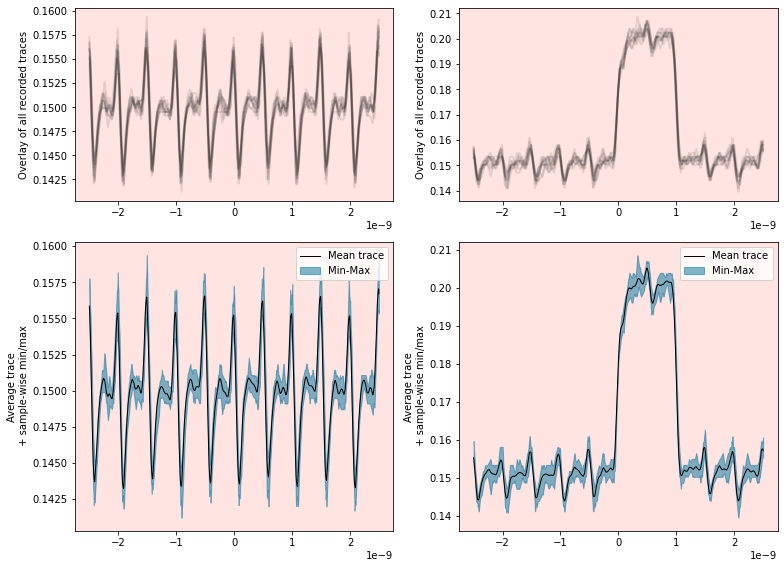

In [28]:
#### Utilizes dicts wrapped in a Class (to allow more convenient argument access)
saved_obj = lab.objdict_root()
saved_obj['params'] = lab.objdict()

#### THIS IS WHAT YOU SHOULD CHANGE ###############
fname = '001_MyDataFile'
acq_channels = (1,3)  # (1,2,3,4) to select oscilloscope channel(s). Must be tuple
repeats = 10 # How many acquisitions in sequence should be taken
osc_channel_info = {'1':"_", 
                    '2':"_",
                    '3':"_",
                    '4':"_"} #use this to describe what is on individual OSC channels 

saved_obj['notes'] = '''
Measurement notes.
''' #can be multi-line

#### THESE ARE SAVED PARAMETERS (can be used to store metadata with data) ###########
saved_obj['params']['devicename'] = "RTD_xyz_123"
saved_obj['params']['I_{vcsel}'] = 2.200e-3
#saved_obj['params']['I_{EDFA}'] = 123e-3
#saved_obj['params']['V_{MZM}'] = 7.67
#saved_obj['params']['V_{SM_mas}'] = 0.830

##### HERE THE ACTUAL MEASURING STARTS, NO NEED TO CHANGE CODE BELOW ##########            
if isHot == True:
    saved_obj = lab.Get_Modulation_Variables(globals(),
                             using_AWG_channels,
                             samplerate,
                             saved_obj) 
    
    measurement = lab.Get_OSC_readouts(acq_channels,
                                       repeats, osc_channel_info,
                                       saved_obj,
                                       awg, rth, sm,
                                       fname,datadir_full,
                                       isSaving)    
else: display (Markdown('<span style="color: #e17701;font-weight:bold">The global acquisition switch (isHot) is set to FALSE. No data recorded.</span>'))

In [ ]:
# Each measurement files has two convenience functions: 
# contents() to show everything in the data file
# plot() to plot the mean for all channels
measurement.contents()
measurement.plot()